# WNTR Fire Flow Demo
This demonstration covers how to run simple fire flow analysis using WNTR.

### 1 Simulation set up

#### 1a Import packages
Numpy and Matplotlib are required to support data handling and graphics/plotting. 

In [1]:
import wntr
import matplotlib.pylab as plt
import numpy as np

# Set colormap for network maps
cmap=plt.cm.get_cmap('viridis')

#### 1b Create a water network model
If adapting code for a different INP file, code for 1b and 1c need to be changed to reflect the correct file path and desired simulation parameters.

In [2]:
# Identify file path to inp file
inp_file = "../networks/Net3.inp"

# Create water network model 
wn = wntr.network.WaterNetworkModel(inp_file)

#### 1c Define fire flow parameters
The parameters `minimum_pressure` and `required_pressure` are used for PDD simulations. Nodes with pressures below minimum pressure will not receive any water, and node pressures need to be at least the required pressure to receive all of the requested demand.

Assuming that there are hydrants at every junction in the network model, hydrants of interest are identified as nodes connnected to pipe diameters of interest. For this reason, a range of pipe diameters to include in the analysis needs to be identified.

In [3]:
# Define simulation parameters 
start_time = 2*3600 # 2 hours
fire_duration = 4*3600 # 4 hours
total_duration = start_time + fire_duration

fire_demand = 0.5047 # 8000 GPM

minimum_pressure = 3.52 # 5 psi
required_pressure = 14.06 # 20 psi

min_pipe_diam = 0.1524 # 6 inch
max_pipe_diam = 0.2032 # 8 inch

### 2 Check normal conditions 

#### 2a Identify non-zero demand (NZD) junctions that fall below minimum pressure during normal conditions 
This step helps determine which junctions that experience low pressures during the disaster simulation are a direct result of the disaster (step 4). 

In [4]:
# Calculate average expected demand and identify junctions with non-zero average expected demand (AED)
AED = wntr.metrics.average_expected_demand(wn)
nzd_junct = AED[AED > 0].index

# Set hydraulic parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure 

# Run simulation
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Save junction pressure results and identify junctions that fall below minimum pressure
pressure = results.node['pressure'].loc[start_time::, nzd_junct]
normal_pressure_below_pmin = pressure.columns[(pressure < minimum_pressure).any()]

### 3 Identify hydrant locations 

#### 3a Query pipes to include in analysis

In [5]:
# Queries pipes with diameters within diameter bounds set in 1b 
pipe_diameter = wn.query_link_attribute('diameter')
pipes_of_interest = pipe_diameter[(pipe_diameter <= max_pipe_diam) & (pipe_diameter >= min_pipe_diam)]

#### 3b Find junctions connected to pipes of interest

In [6]:
# Queries junctions connected to pipes of interest
junct_of_interest = set()
for pipe_name in pipes_of_interest.index:
    pipe = wn.get_link(pipe_name)
    if pipe.start_node_name in wn.junction_name_list:
        junct_of_interest.add(pipe.start_node_name)
    if pipe.end_node_name in wn.junction_name_list:
        junct_of_interest.add(pipe.end_node_name)

### 4 Simulate hydraulics

A try/except/finally approach is taken to ensure the script can finish running and still catch any convergence issues increased fire flow might cause. A user can revisit nodes with failed simulations individually to determine the cause of failure, if desired. 

In [7]:
# Create dictionary to save results
analysis_results = {}

# Simulate fire flow demand for each hydrant location
for junct in junct_of_interest:
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'    
    wn.options.time.duration = total_duration
    wn.options.hydraulic.minimum_pressure = minimum_pressure
    wn.options.hydraulic.required_pressure = required_pressure

    # Create fire flow pattern
    fire_flow_pattern = wntr.network.elements.Pattern.binary_pattern(
        'fire_flow',
        start_time=start_time,
        end_time=total_duration,
        step_size=wn.options.time.pattern_timestep,
        duration=wn.options.time.duration
        )
    wn.add_pattern('fire_flow', fire_flow_pattern)

    # Apply fire flow pattern to hydrant location
    fire_junct = wn.get_node(junct)
    fire_junct.demand_timeseries_list.append((fire_demand, fire_flow_pattern, 'Fire flow'))

    try:
        # Simulate hydraulics
        sim = wntr.sim.WNTRSimulator(wn) 
        sim_results = sim.run_sim()
 
        # Using pressure results, identify impacted junctions
        sim_pressure = sim_results.node['pressure'].loc[start_time::, nzd_junct]
        sim_pressure_below_pmin = sim_pressure.columns[(sim_pressure < minimum_pressure).any()]
        impacted_junctions = set(sim_pressure_below_pmin) - set(normal_pressure_below_pmin)
        
    except Exception as e:
        # Identify failed simulations and the reason
        impacted_junctions = None
        print(junct, ' Failed:', e)

    finally:
        # Save simulation results
        analysis_results[junct] = impacted_junctions

### 5 Visualize results

#### 5a Calculate junction and population impacts

In [8]:
# Calculate population per junction
population = wntr.metrics.population(wn)

# Save junction and population impact results to dictionary
num_junctions_impacted = {}
num_people_impacted = {}
for pipe_name, impacted_junctions in analysis_results.items():
    if impacted_junctions is not None:
        num_junctions_impacted[pipe_name] = len(impacted_junctions)
        num_people_impacted[pipe_name] = population[impacted_junctions].sum()

#### 5b Plot results
If a different INP file from the example Net3.inp file is being used, the parameter `node_range` can be adjusted to better suit the simulation results.

<AxesSubplot:title={'center':'Number of people impacted by each fire flow demand'}>

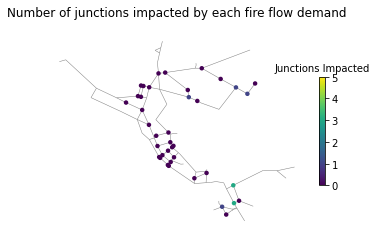

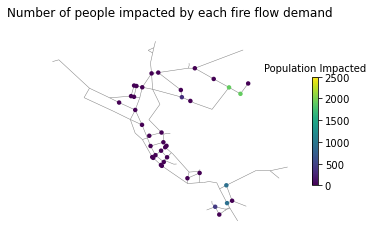

In [9]:
#Plot junctions impacted due to increased fire flow
wntr.graphics.plot_network(wn, node_attribute=num_junctions_impacted, node_size=20, link_width=0, 
                           node_range=[0,5], node_cmap = cmap, node_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each fire flow demand')

#Plot population impacted due to increased fire flow
wntr.graphics.plot_network(wn, node_attribute=num_people_impacted, node_size=20, link_width=0, 
                           node_range=[0,2500], node_cmap = cmap, node_colorbar_label='Population Impacted',
                           title='Number of people impacted by each fire flow demand')                    

#### Data Testing
The following code is included for data testing and is not required for fire flow analysis.

In [10]:
import pandas as pd

# Test simulation results
# Import expected results
junct_test = pd.read_csv('../../wntr/tests/data_for_testing/fire_flow_demo_junction_test_data.csv', index_col=0, squeeze=True).to_dict()
junct_test = {str(key): value for key, value in junct_test.items()}

people_test = pd.read_csv('../../wntr/tests/data_for_testing/fire_flow_demo_people_test_data.csv', index_col=0, squeeze=True).to_dict()
people_test = {str(key): value for key, value in people_test.items()}

# Check if simulation results match expected results
assert num_junctions_impacted == junct_test, "impacted junction results differ"
assert num_people_impacted == people_test, "impacted people results differ"